# Question 2: Training and using materials models
**2.1 data cleaning and splitting**

In a Materials informatics workflow you need to find and clean data, featurize the data, train models, and use models for some task. A few years ago, we put together a nice series of notebooks that describe this process for an example where we train heat capacity data as a function of temperature and composition and then use this model to predict heat capacity as a function of temperature for new materials. The best practices document is a great starting point for you and can be found here `https://github.com/anthony-wang/BestPractices`. I'd like you to go through a similar exercise as the best practices notebook but with a few changes. 

**<font color='teal'>a)</font>** First, you'll notice that the original notebooks used `pandas-profiling` but this has been deprecated and replaced by ydata-profiling. Try to get ydata-profiling to work and then use it to inspect your data. 

In [1]:
# It works but the widget it porduces is not scrollable 
# and my computer slows down like crazy

#from ydata_profiling import ProfileReport
#import pandas as pd

#df=pd.read_csv('svm_df.csv')
#profile = ProfileReport(df, title="Profiling Report")
#profile.to_widgets()

# using the _atomic_environment_features_binary combined with the density data
# results in a lot of data that is strongly correlated and redundant



**<font color='teal'>b)</font>** Second, in the data-splitting notebook, you'll see how we came up with an elaborate way to make sure tha as we split the data, we made sure that all the values corresponding to a formula went to either test, val, or train but would never be randomly split across these groups. We were silly and didn't know about `GroupKFold` in teh scikit-learn library. (`https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html`) Redo the splitting process using this much simpler tool. 


In [2]:
#code goes here
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import sys
import os
from CBFV import composition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

filename = 'C:\cp_data_demo.csv'

df=pd.read_csv(filename)
rename_dict = {'CONDITION: Temperature (K)':'Temperature', 'PROPERTY: Heat Capacity (J/mol K)':'Heat_Cap', 'FORMULA':'formula'}
df = df.rename(columns=rename_dict)
df = df.dropna()
df = df.reset_index(drop=True)
#print(df)
nunique=df.nunique()
print(nunique)
unique_vals=pd.Series({c: df[c].unique() for c in df})

X = df['Temperature']
y = df['Heat_Cap']

groups = df['formula']


gkf = GroupKFold(n_splits=nunique['formula'])

for i,(train_index, test_index) in enumerate(gkf.split(df,groups= df['formula'])):
    #print("Train:", train_index, "Test:", test_index)
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}") 
    #print(f"  group={groups[train_index]}")
    #print(f"  Test:  index={test_index}")
    #print(f"  group={groups[test_index]}")
    
    train_fold = pd.DataFrame({'train_group':groups[train_index],'train_index':train_index})
    train_fold.to_csv("train_fold"+str(groups[test_index[0]])+".csv")
    test_fold = pd.DataFrame({'test_group':groups[test_index],'test_index':test_index})
    test_fold.to_csv("test_fold"+str(groups[test_index[0]])+".csv")





formula         244
Temperature     237
Heat_Cap       3632
dtype: int64


**2.2 model training and hyper parameter tuning**

**<font color='teal'>c)</font>** Next, when we built our classic models, we never performed hyperparameter tuning! We just used them with default parameters. I'd like you to build two models and perform hyperparameter tuning on them. One model should be either `Ridge` or `Lasso` and the other should be `XGBoost`. Compare performance metrics including training time. 

In [3]:
# Featurize the data 
filename = 'C:\cp_data_demo.csv'
df=pd.read_csv(filename)
rename_dict = {'CONDITION: Temperature (K)':'Temperature', 'PROPERTY: Heat Capacity (J/mol K)':'target', 'FORMULA':'formula'}
df = df.rename(columns=rename_dict)
df = df.dropna()
df = df.reset_index(drop=True)
#print(df)

train_indices = pd.read_csv("train_foldZr1.csv")
train_indices = train_indices['train_index']
#print(train_indices)
test_indices = pd.read_csv("test_foldZr1.csv")
test_indices = test_indices['test_index']

train_df = df.iloc[train_indices]
#print(train_df)
test_df = df.iloc[test_indices]
print(test_df)

X_train_feats_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(train_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_feats_unscaled, y_test, formulae_train, skipped_train = composition.generate_features(test_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

X_train_feats_unscaled.to_csv("X_train_feats_unscaled.csv")


     formula  Temperature  target
4553     Zr1       1600.0  37.762
4554     Zr1       1500.0  36.846
4555     Zr1       1400.0  35.807
4556     Zr1       1300.0  34.681
4557     Zr1       1200.0  33.502
4558     Zr1       1135.0  32.724
4559     Zr1       1100.0  32.306
4560     Zr1       1000.0  31.128
4561     Zr1        900.0  30.003
4562     Zr1        800.0  28.966
4563     Zr1        700.0  28.053
4564     Zr1        600.0  27.281
4565     Zr1        500.0  26.564
4566     Zr1        450.0  26.246
4567     Zr1        400.0  25.935
4568     Zr1        350.0  25.606
4569     Zr1        298.0  25.202


Processing Input Data: 100%|██████████| 4553/4553 [00:00<00:00, 9047.82it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4553/4553 [00:01<00:00, 3693.36it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 17/17 [00:00<00:00, 5975.29it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 17/17 [00:00<00:00, 1677.13it/s]


	Creating Pandas Objects...


In [4]:
#X_train_feats_unscaled.to_csv("X_train_unscaled.csv")
print(y_train)

0       134.306
1       131.294
2       128.072
3       124.516
4       120.625
         ...   
4548     26.843
4549     26.346
4550     25.889
4551     25.406
4552     25.387
Name: target, Length: 4553, dtype: float64


In [5]:
df=pd.read_csv(filename)
rename_dict = {'CONDITION: Temperature (K)':'Temperature', 'PROPERTY: Heat Capacity (J/mol K)':'target', 'FORMULA':'formula'}
df = df.rename(columns=rename_dict)
df = df.dropna()

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_feats_unscaled)
X_test = scaler.transform(X_test_feats_unscaled)

# Normalize the data
X_train = normalize(X_train)
#X_val = normalize(X_val)
X_test = normalize(X_test)


the r2 score is 0.9675976098706123
the mean absolute error is 0.5886897353338507


Model score :  0.9675976098706123


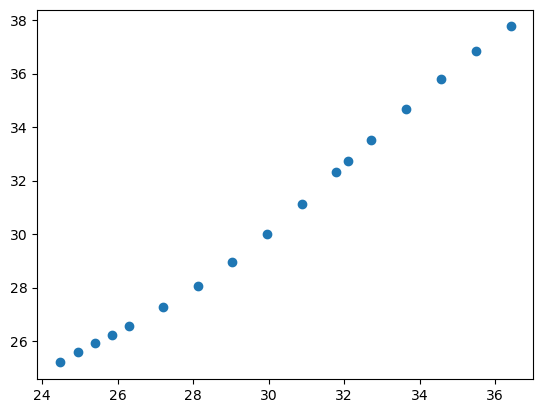

In [6]:
# Ridge
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#RNG_SEED = 42
#np.random.seed(seed=RNG_SEED)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RNG_SEED)
  
# training model with 0.5 alpha value 
ridge = Ridge(alpha = 0.5, tol = 0.001,
              solver ='auto', random_state = 42) 
ridge.fit(X_train, y_train) 
  
# predicting the y_test 
y_pred = ridge.predict(X_test) 
r2 = r2_score(y_test, y_pred)
print('the r2 score is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)
  
# finding score for our model 
score = ridge.score(X_test, y_test) # model score is r^2 value
print("\n\nModel score : ", score) 



c:\Miniconda3\envs\MatInformatics\lib\site-packages\xgboost\core.py:160: UserWarning: [10:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


the r2 score is -0.5231982094772158
the mean absolute error is 4.4842320323270926


Model score :  -0.5231982094772158


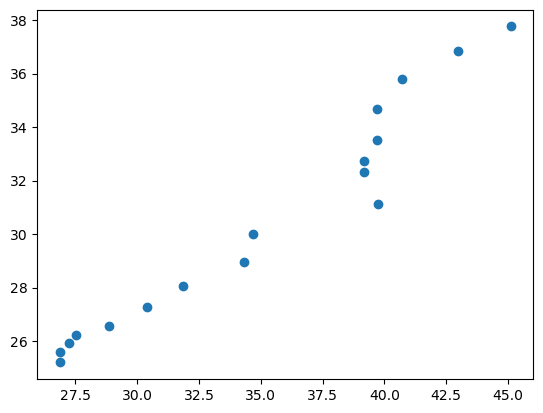

In [7]:
# XGBoost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Use "hist" for training the model.
XGBoost = xgb.XGBRegressor(tree_method="hist", device="cuda")
# Fit the model using predictor X and response y.
XGBoost.fit(X_train, y_train)

y_pred=XGBoost.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('the r2 score is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)

score = XGBoost.score(X_test, y_test)
print("\n\nModel score : ", score)

# Save model into JSON format.
#reg.save_model("regressor.json")


**2.3 using your model to make predictions**

**<font color='teal'>c)</font>** Finally, pick the best model from **2.2** and use it to predict the heat capacity from 1200K to 2000K for ZrN. See how it compares to experiment. 

![ZrN Cp](https://www.researchgate.net/publication/335403917/figure/fig2/AS:796198449467394@1566839911338/High-temperature-heat-capacity-Cp-of-zirconium-and-hafnium-carbides-and-carbonitrides.png)


Processing Input Data: 100%|██████████| 9/9 [00:00<00:00, 3837.42it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 9/9 [00:00<00:00, 3540.49it/s]

	Creating Pandas Objects...


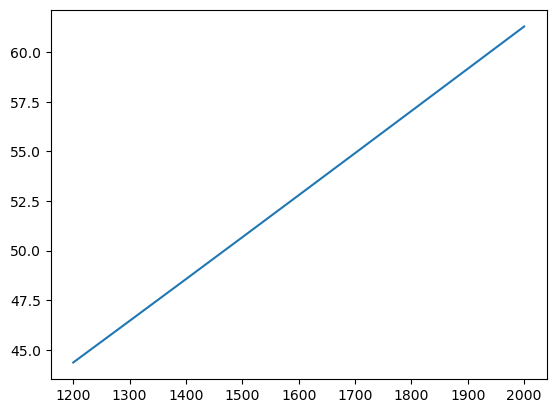

In [8]:

pred_data = {"formula":['ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN'],"Temperature":[1200,1300,1400,1500,1600,1700,1800,1900,2000],'target':[0,0,0,0,0,0,0,0,0]}
pred_df = pd.DataFrame(data=pred_data)

X_pred_unscaled, y_pred, formulae_train, skipped_train = composition.generate_features(pred_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

# Scale the data
X_pred_unscaled = scaler.transform(X_pred_unscaled)
# Normalize the data
X_pred = normalize(X_pred_unscaled)

# Ridge Model
y_pred=ridge.predict(X_pred)
plt.plot([1200,1300,1400,1500,1600,1700,1800,1900,2000],y_pred)
